# Analise do Dataset

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

In [3]:
X_dataset_raw = pd.read_csv('datasets/KV-BothApps-PeriodicLoad/X_port.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(X_dataset_raw.shape)
print(X_dataset_raw.iloc[0, 0])
print(X_dataset_raw.iloc[-1, 0])
X_dataset_raw.head(5)

(26488, 177)
1479739985
1479783145


,TimeStamp,0_RxPacktes,0_TxPacktes,0_RxBytes,0_TxBytes,1_RxPacktes,1_TxPacktes,1_RxBytes,1_TxBytes,2_RxPacktes,...,41_RxBytes,41_TxBytes,42_RxPacktes,42_TxPacktes,42_RxBytes,42_TxBytes,43_RxPacktes,43_TxPacktes,43_RxBytes,43_TxBytes
0,1479739985,7108,4337,7708850,1479936,2460,3771,743887,6795688,0,...,219650,5266896,3861,2444,4298810,1149436,2440,3869,726640,7115363
1,1479739995,8893,6683,8317814,2682692,2283,3595,597381,6531850,0,...,1142826,6675731,3699,2385,4102066,1021228,2383,3654,653280,6687710
2,1479739996,7443,5465,7750330,2511507,2088,3465,568282,6549788,0,...,1069564,6127567,3345,2057,3854494,856046,2056,3390,549007,6504818
3,1479739997,7646,5584,8096035,2576963,2094,3421,610830,6422575,0,...,1036988,7207488,3385,2098,3782213,987682,2105,3354,624669,6261674
4,1479739998,7960,5612,8658786,2583418,2212,3529,659478,6488800,0,...,991118,6903020,3780,2214,4387110,1015404,2210,3799,644452,7415177


In [4]:
# Identify columns to normalize (all except the first)
cols_to_normalize = X_dataset_raw.columns[1:]

# Extract the columns to be normalized
df_to_normalize = X_dataset_raw[cols_to_normalize]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
normalized_data = scaler.fit_transform(df_to_normalize)

# Create a new DataFrame with the normalized values
X_dataset_norm = pd.DataFrame(normalized_data, columns=cols_to_normalize, index=X_dataset_raw.index)

# Concatenate the first column with the normalized DataFrame
X_dataset_norm = pd.concat([X_dataset_raw.iloc[:, :1], X_dataset_norm], axis=1)

# Print the final DataFrame
print(X_dataset_norm.shape)
X_dataset_norm.head(5)

(26488, 177)


,TimeStamp,0_RxPacktes,0_TxPacktes,0_RxBytes,0_TxBytes,1_RxPacktes,1_TxPacktes,1_RxBytes,1_TxBytes,2_RxPacktes,...,41_RxBytes,41_TxBytes,42_RxPacktes,42_TxPacktes,42_RxBytes,42_TxBytes,43_RxPacktes,43_TxPacktes,43_RxBytes,43_TxBytes
0,1479739985,0.416197,0.278305,0.476688,0.182595,0.584880,0.603936,0.746216,0.566574,0.0,...,0.049750,0.293769,0.625608,0.573646,0.595296,0.798280,0.573471,0.626971,0.702640,0.598632
1,1479739995,0.599180,0.539989,0.528852,0.438835,0.525143,0.567856,0.585770,0.541761,0.0,...,0.402619,0.421621,0.592788,0.554161,0.564706,0.703367,0.554521,0.583502,0.623939,0.558216
2,1479739996,0.450538,0.404127,0.480241,0.402365,0.459332,0.541205,0.553903,0.543448,0.0,...,0.374616,0.371875,0.521070,0.445839,0.526213,0.581083,0.445811,0.530125,0.512075,0.540932
3,1479739997,0.471348,0.417401,0.509854,0.416310,0.461357,0.532185,0.600499,0.531484,0.0,...,0.362164,0.469878,0.529173,0.459379,0.514974,0.678533,0.462101,0.522847,0.593245,0.517953
4,1479739998,0.503537,0.420524,0.558059,0.417685,0.501181,0.554326,0.653776,0.537712,0.0,...,0.344631,0.442248,0.609198,0.497688,0.609025,0.699056,0.497008,0.612818,0.614468,0.626967


0_RxPacktes     0
0_TxPacktes     0
0_RxBytes       0
0_TxBytes       0
1_RxPacktes     0
               ..
42_TxBytes      0
43_RxPacktes    0
43_TxPacktes    0
43_RxBytes      0
43_TxBytes      0
Length: 176, dtype: int64


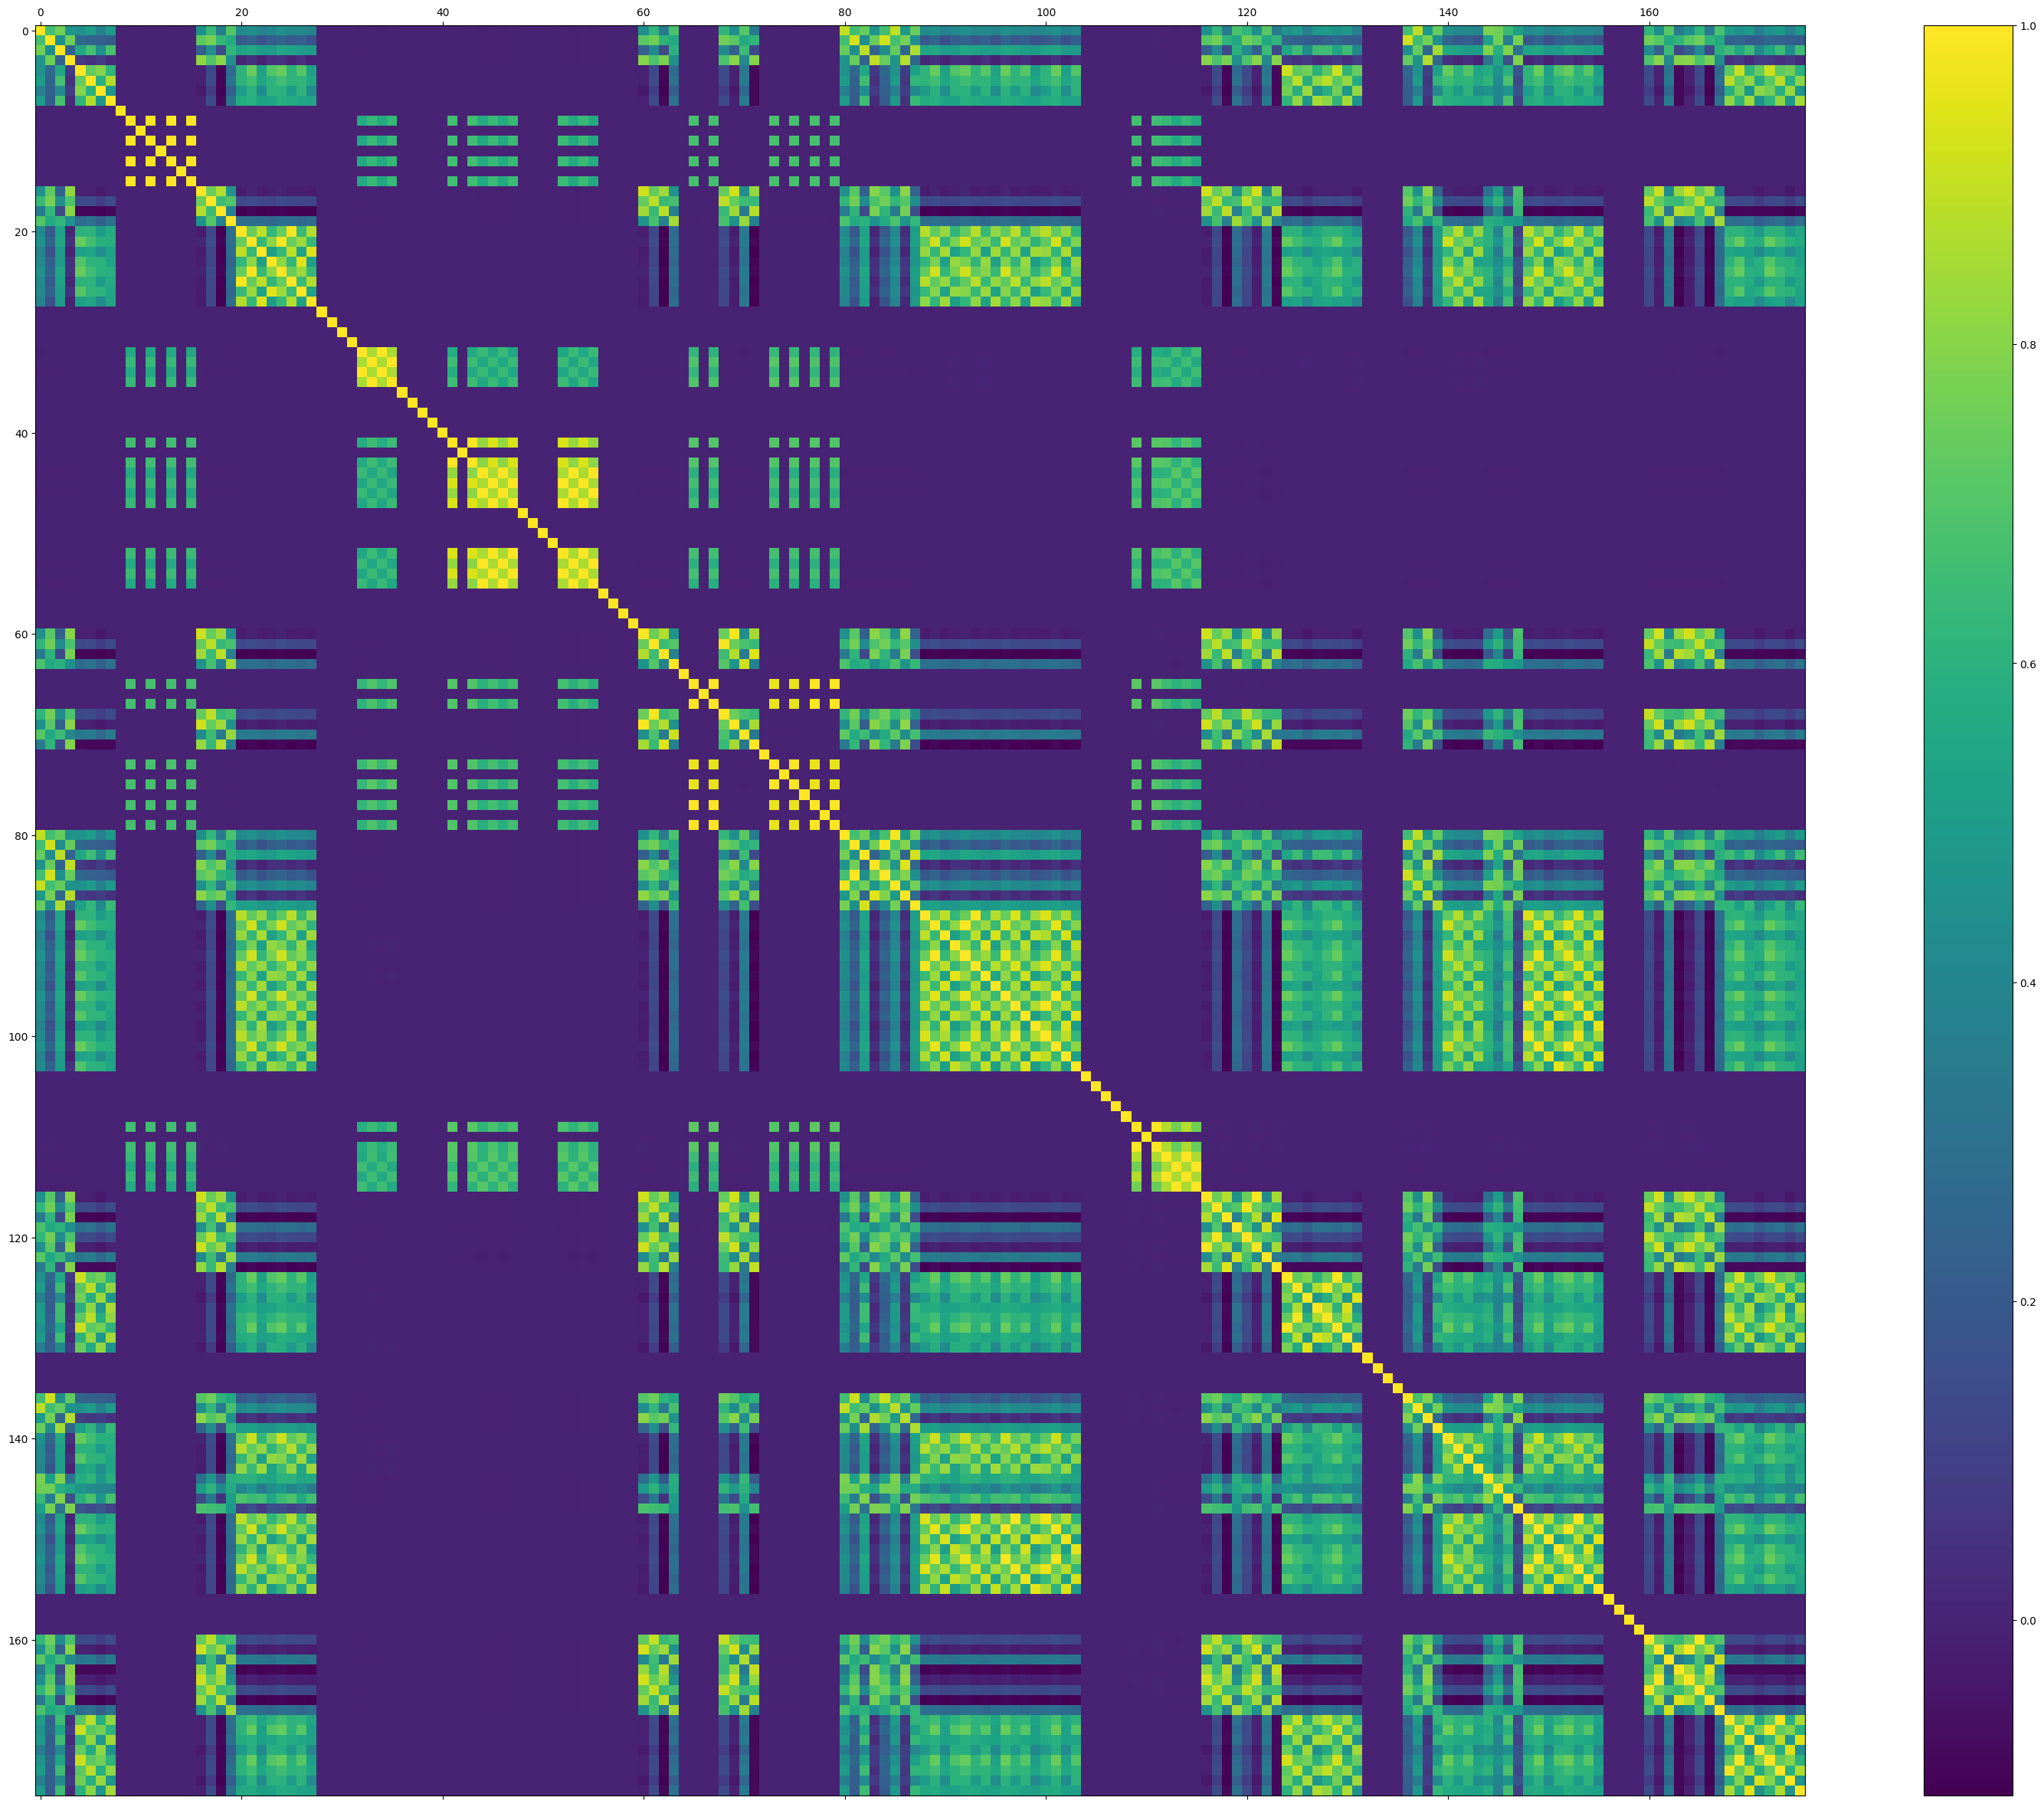

In [33]:
# correlate all columns excluding the first one. checking if exists interdenpendency between them...
X_df_subset = X_dataset_norm.iloc[:, 1:]

print(X_df_subset.isnull().sum())

# calculate correlation matrix for the subset
correlation_matrix = X_df_subset.corr(method='kendall')
correlation_matrix = correlation_matrix.fillna(0)

# print(correlation_matrix)

# show heatmap with correlation_matrix
fig, ax = plt.subplots(figsize=(40, 30))
heatmap = ax.matshow(correlation_matrix, interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

# antes de correlacionar, fazer normalizacao....
# correlacionar as features entre si... se existe interdependencia entre elas...

# nmae e meansquarederror

# homocedasticidade - teste de Breusch-Pagan
# teste de Durbin-Watson (nas features)

# se tiver correlacao linear explicada por regressão... executar coeficiente de determinação pra avaliar o percentual de dados explicados pelo modelo...

In [5]:
y_dataset = pd.read_csv('datasets/KV-BothApps-PeriodicLoad/Y.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
y_dataset.head(5)

,TimeStamp,ReadsAvg,WritesAvg
0,1479739985,62.0532,123.8074
1,1479739995,55.9480,114.3893
2,1479739996,60.4136,119.6193
3,1479739997,66.8118,126.0616
4,1479739998,75.1909,172.2968


In [6]:
y = y_dataset[['ReadsAvg']].copy()
y.head(5)

,ReadsAvg
0,62.0532
1,55.9480
2,60.4136
3,66.8118
4,75.1909


In [7]:
# use this https://www.digitalocean.com/community/tutorials/multiple-linear-regression-python#using-statsmodels, to get some statistical information...
X_df_train_without_ts = X_dataset_norm.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
y_normalized_data = scaler.fit_transform(y)

# Create a new DataFrame with the normalized values
y_norm = pd.DataFrame(y_normalized_data, index=y.index)

# Add a constant to the model
X_train_sm = sm.add_constant(X_df_train_without_ts)
model_sm = sm.OLS(y_norm, X_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     105.3
Date:                Wed, 11 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:55:46   Log-Likelihood:                 48586.
No. Observations:               26488   AIC:                        -9.692e+04
Df Residuals:                   26362   BIC:                        -9.589e+04
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0464      0.013     -3.520   

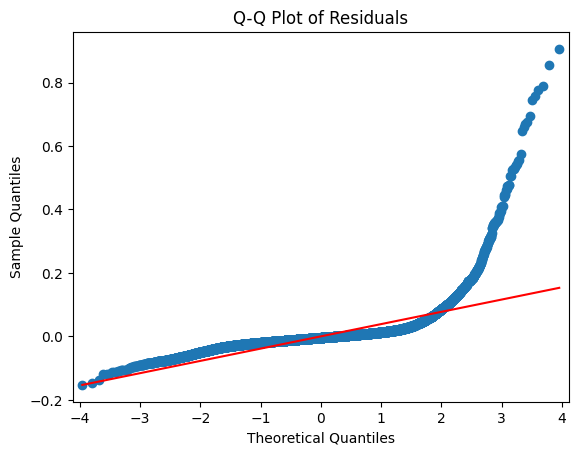

In [8]:
# Q-Q Plot for residuals
fig = sm.qqplot(model_sm.resid, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Saving plot...
# fig.savefig('pictures/qq_plot_residuals.png', dpi=fig.dpi, format='png')

In [9]:
correlations = []

# print(X_df_train_without_ts)
# print(y_norm)

for idx, col in enumerate(X_df_train_without_ts.columns):
    # print(X_df_train_without_ts[col])
    # print(y_norm.iloc[:,0])
    # break
    correlations.append([col, X_df_train_without_ts[col].corr(y_norm.iloc[:,0])])

print(len(correlations))
# correlations

176


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Strong corr: 1
Moderate corr: 70
Weak corr: 105


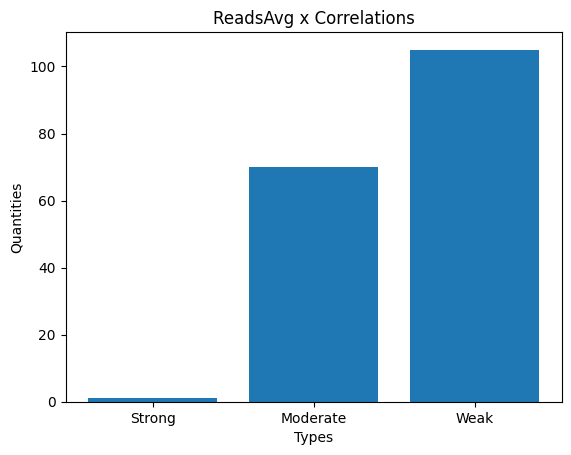

In [49]:
# create a plot with quantity of columns as of strong, medium and low correlation...
# Strong Correlation:
# A correlation coefficient of 0.5 to 1.0 (positive) or -0.5 to -1.0 (negative). 
# Moderate Correlation:
# A correlation coefficient of 0.3 to 0.5 (positive) or -0.3 to -0.5 (negative).
# Weak Correlation:
# A correlation coefficient of 0.1 to 0.3 (positive) or -0.1 to -0.3 (negative).
strong_corr = []
moderate_corr = []
weak_corr = []

for col_corr in correlations:
    if not np.isnan(col_corr[1]):
        if 1.0 >= col_corr[1] > 0.5 or -0.5 > col_corr[1] >= -1.0:
            strong_corr.append(col_corr[0])
        elif 0.5 >= col_corr[1] > 0.3 or -0.3 > col_corr[1] >= -0.5:
            moderate_corr.append(col_corr[0])
        elif 0.3 >= col_corr[1] > 0.0 or -0.1 >= col_corr[1] >= -0.3:
            weak_corr.append(col_corr[0])
        else:
            weak_corr.append(col_corr[0])
    else:
        weak_corr.append(col_corr[0])

print('Strong corr:', len(strong_corr))
print('Moderate corr:', len(moderate_corr))
print('Weak corr:', len(weak_corr))

correlation_bar = np.array([len(strong_corr), len(moderate_corr), len(weak_corr)])

# plot
corr_types = ['Strong', 'Moderate', 'Weak']

fig = plt.figure()
plt.bar(corr_types, correlation_bar)
plt.title('ReadsAvg x Correlations')
plt.xlabel('Types')
plt.ylabel('Quantities')
plt.show()

# Saving plot...
fig.savefig('pictures/corr_readsavg_qty_features.png', dpi=fig.dpi, format='png')

# We will use moderate correlations to create our model and then use PCA to create a second model and check 
# which of them is the best one.

In [111]:
# Correlation between ReadsAvg and WritesAvg
y_dataset.corr()
# y_dataset['ReadsAvg'].corr(y_dataset['WritesAvg'])
correlations = {
    'columns': [],
    'values': np.empty(shape=(176, 2))
}


for idx, col in enumerate(X_dataset.columns):
    if idx == 0:
        continue
    readsavg_corr = X_dataset[col].corr(y_dataset['ReadsAvg'])
    writesavg_corr = X_dataset[col].corr(y_dataset['WritesAvg'])
    correlations['columns'].append(col)
    correlations['values'][idx - 1] = np.nan_to_num(np.array([readsavg_corr, writesavg_corr]), nan=0)

print(correlations['values'].shape)
correlations['values']

(176, 2)


array([[ 4.75637254e-01,  4.33556182e-01],
       [ 4.95379367e-01,  4.56410080e-01],
       [ 3.82384329e-01,  3.45241195e-01],
       [ 3.97390607e-01,  3.71278933e-01],
       [ 3.08404144e-01,  2.74760643e-01],
       [ 2.87219053e-01,  2.54719303e-01],
       [ 2.50206277e-01,  2.21914337e-01],
       [ 2.53490006e-01,  2.24172820e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.46983013e-03,  3.71584573e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 8.86812688e-04,  2.16891369e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.48733232e-03,  3.73908683e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 8.97612435e-04,  2.18325614e-03],
       [ 4.07003655e-01,  3.78998502e-01],
       [ 4.43600761e-01,  4.09390794e-01],
       [ 3.42784228e-01,  3.22429078e-01],
       [ 3.68294339e-01,  3.38359300e-01],
       [ 2.78073111e-01,  2.47921004e-01],
       [ 3.30438235e-01,  2.96670119e-01],
       [ 2.42074520e-01,  2.14606012e-01],
       [ 3.

In [112]:
correlations['values'][:, 0].shape

(176,)

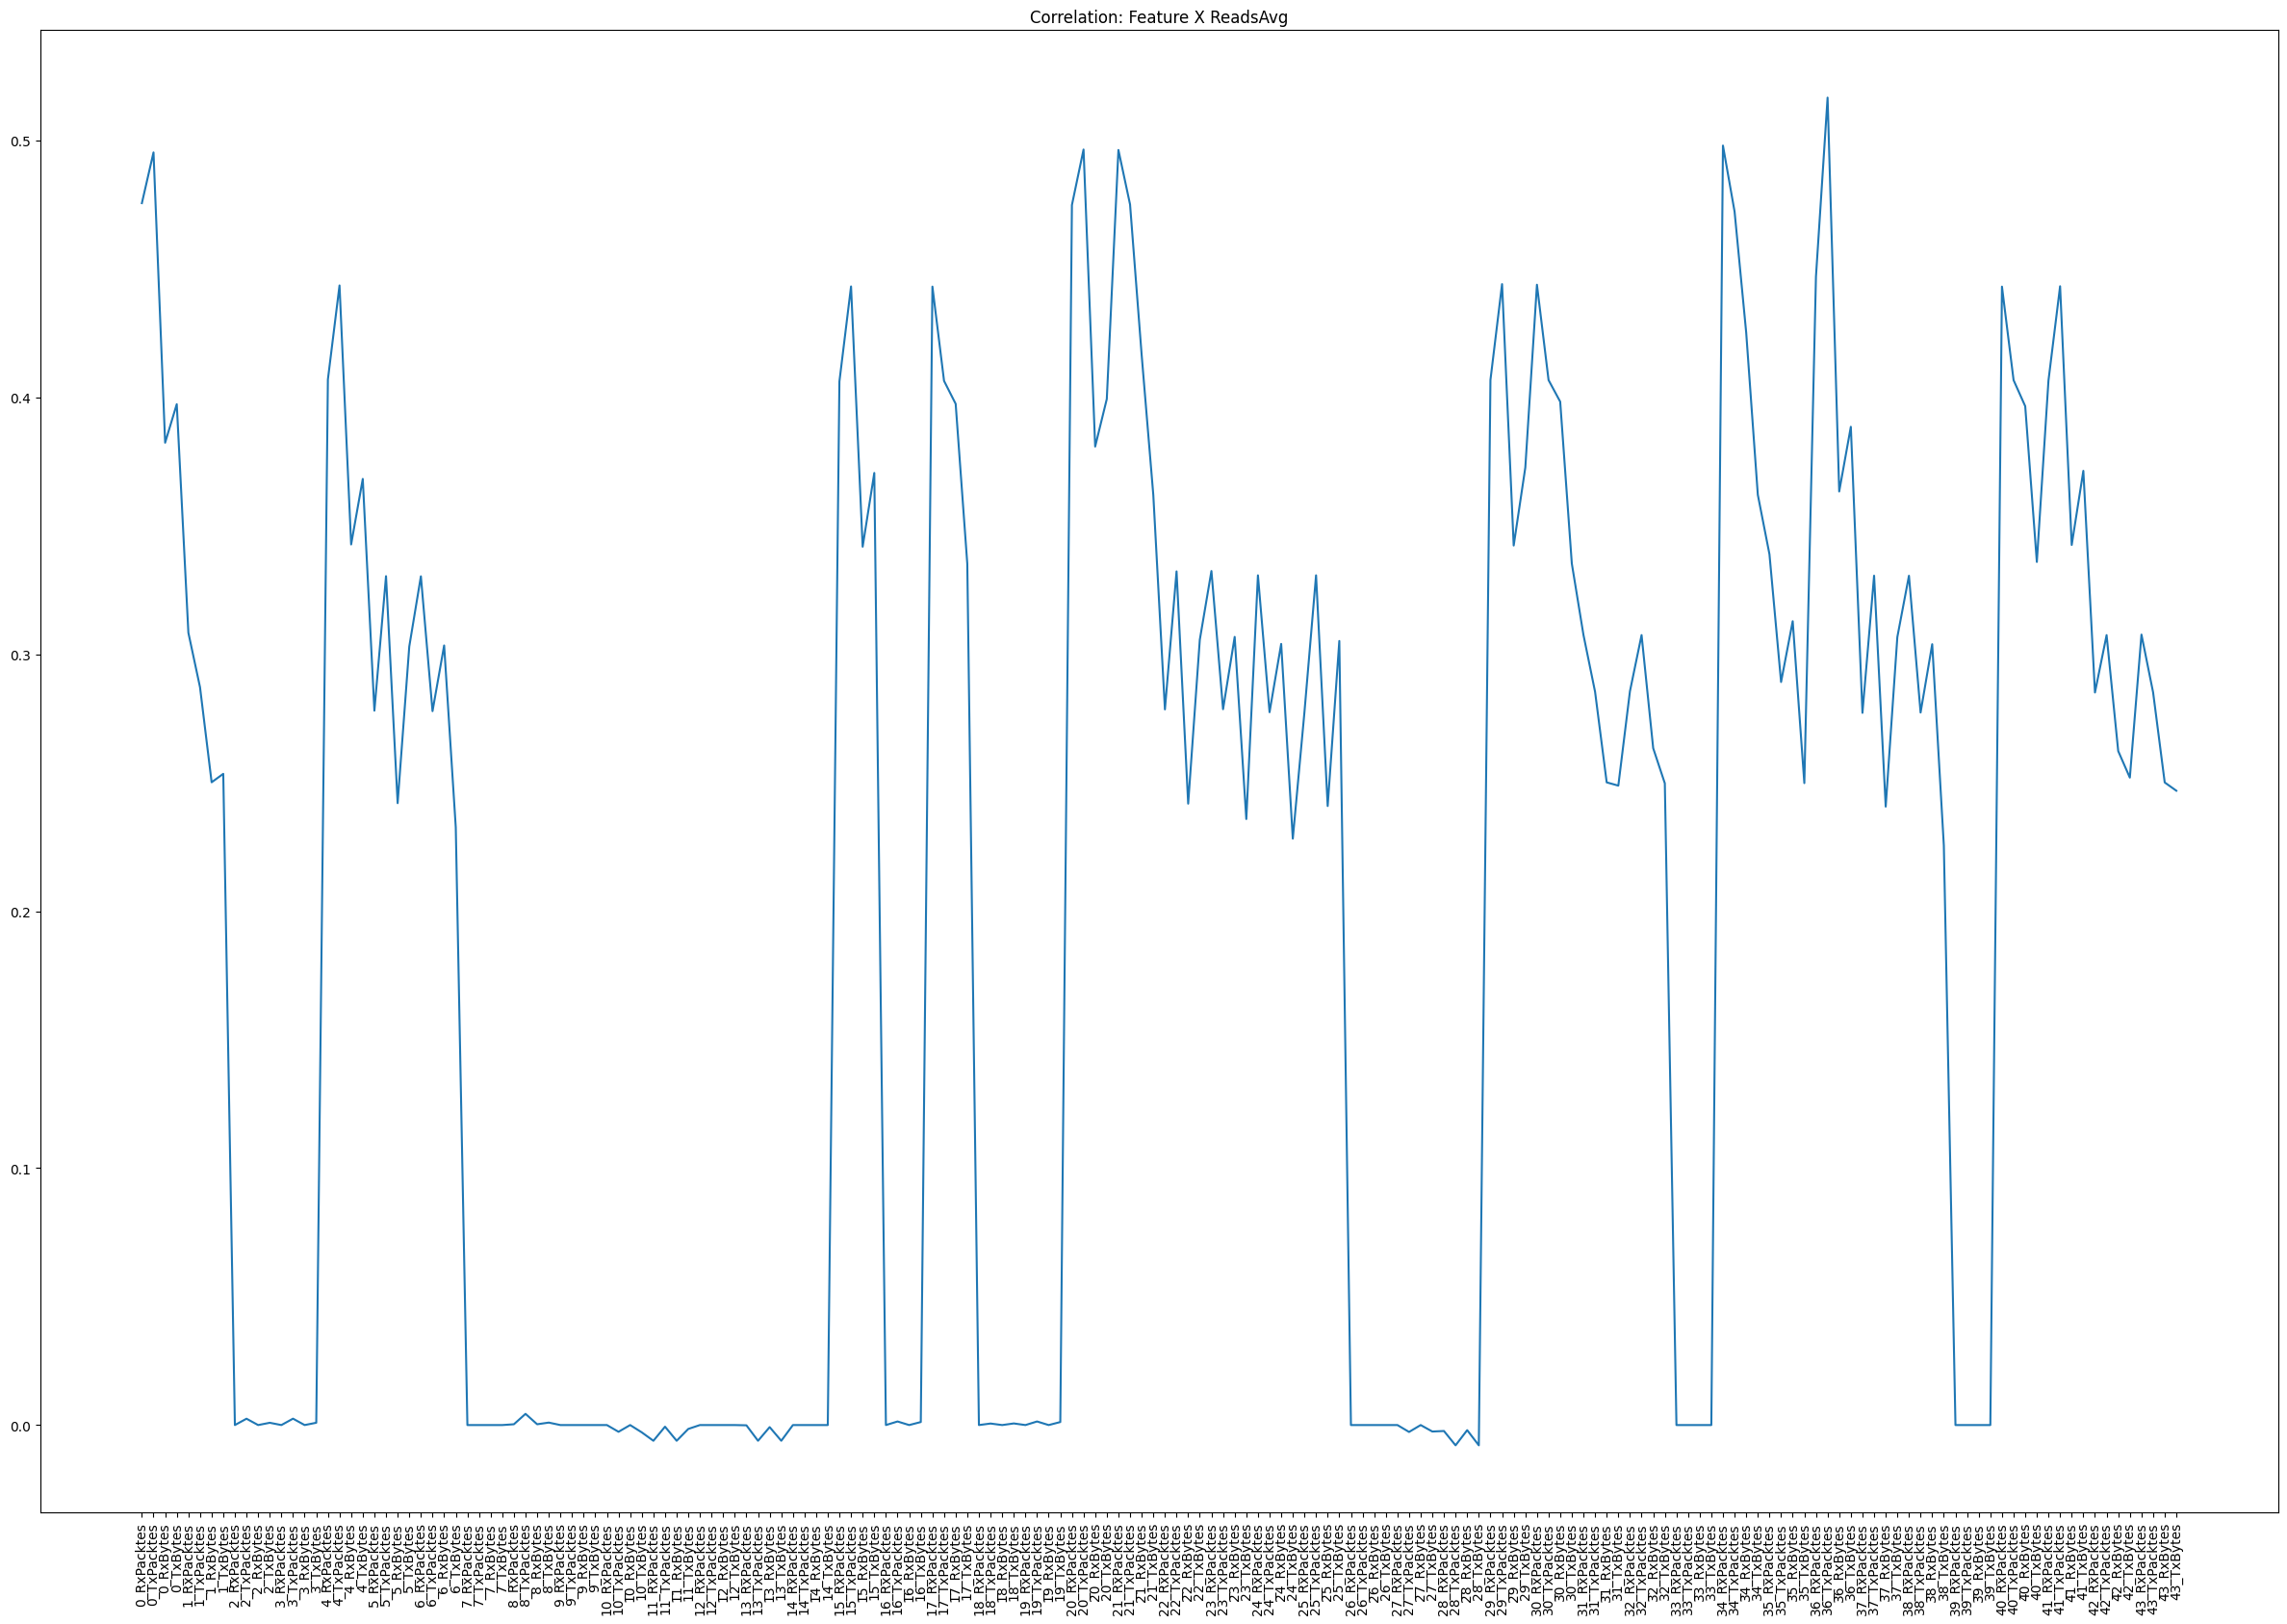

In [114]:
# Heatmap of correlations between columns and ReadsAvg, WritesAvg
# np_correlations = np.array(correlations['values'])
# np_correlations = np_correlations.transpose()

# plt.figure(figsize=(50,50))
x_axis = list(range(len(correlations['columns'])))
# print(x_axis)

# correlations['values'][:, 0]
fig = plt.figure(figsize=(30, 20))
plt.plot(x_axis, correlations['values'][:, 0]) # matrix[:, column_index] 


plt.xticks(x_axis, correlations['columns'], rotation='vertical')
  
# # # Add colorbar 
# # plt.colorbar() 
  
plt.title("Correlation: Feature X ReadsAvg") 
plt.show()

In [118]:
# Saving plot...
# fig.savefig('pictures/correlation_columns_readsavg.png', dpi=fig.dpi, format='png')

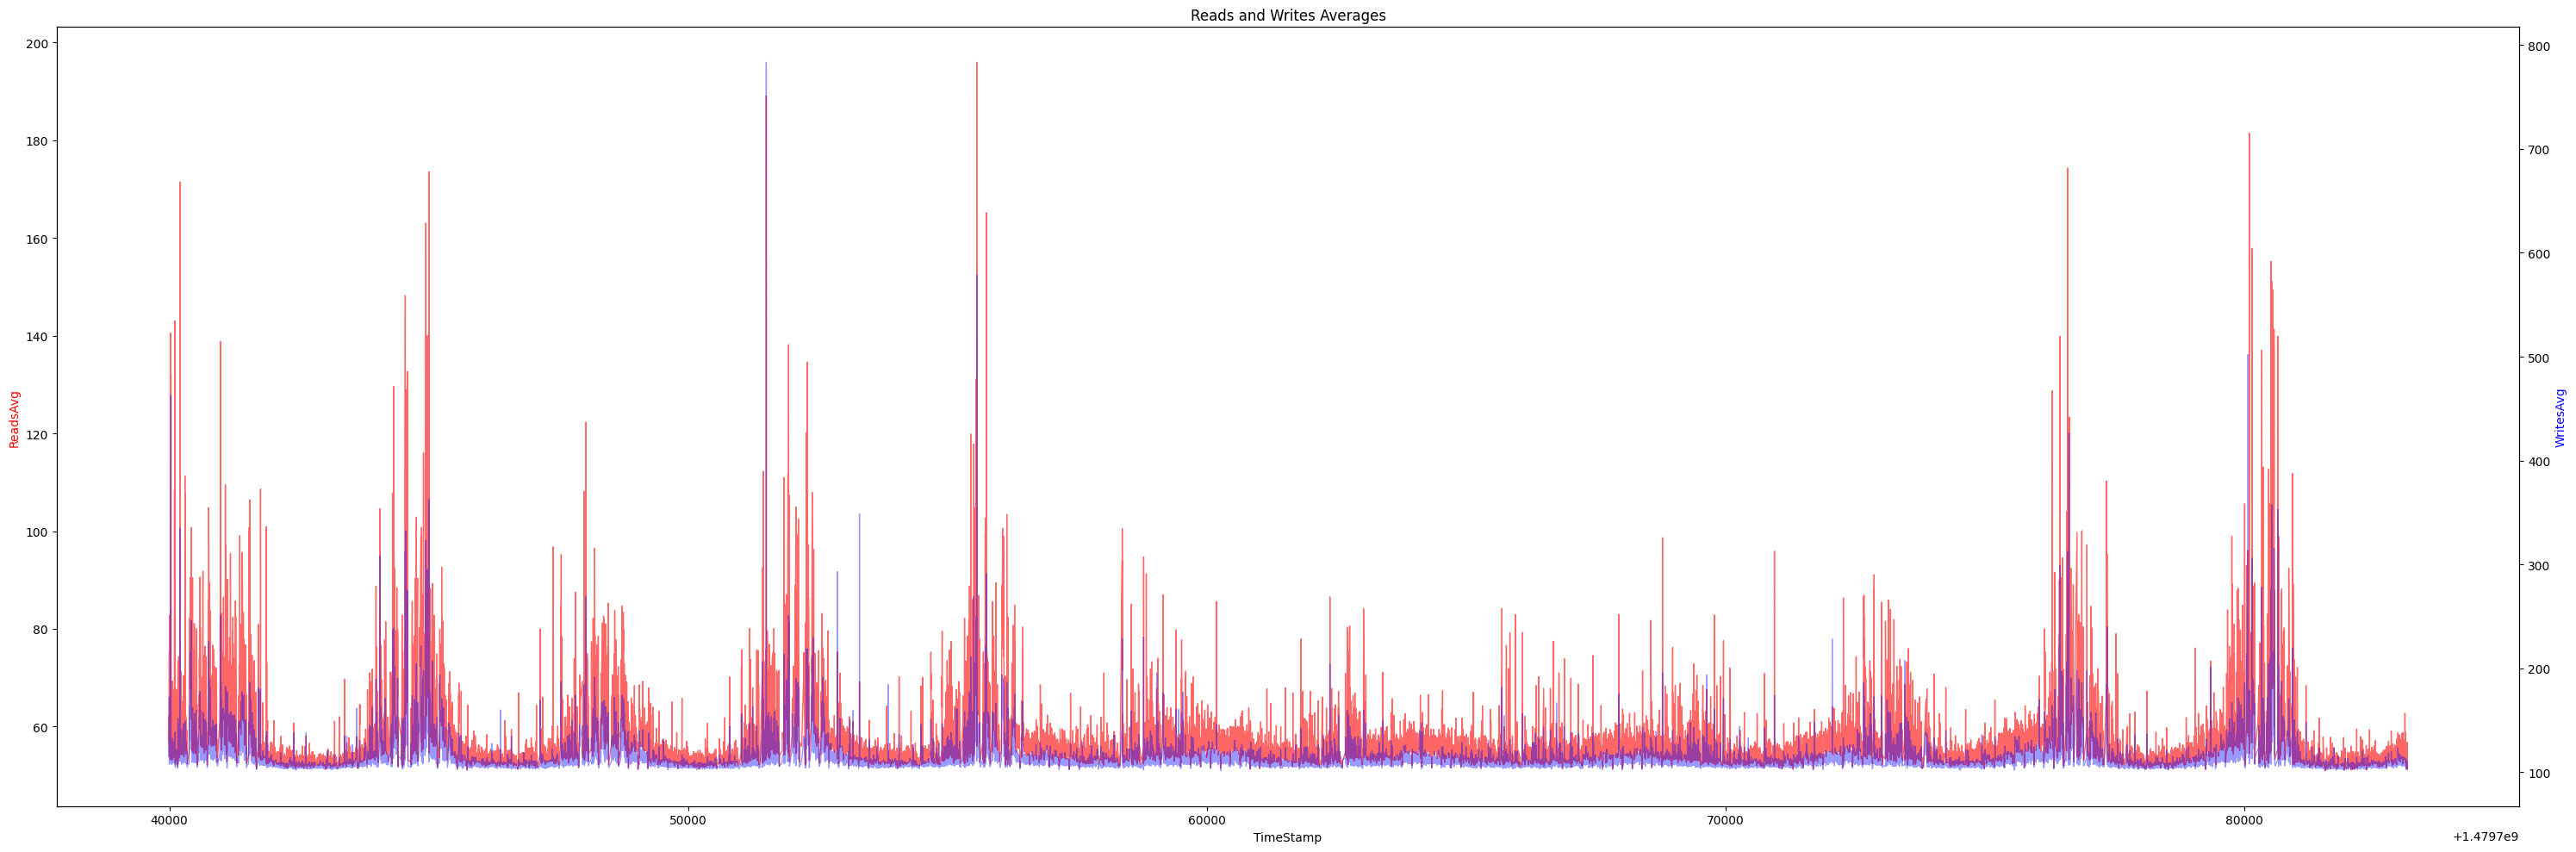

In [17]:
# Plot of ReadsAvg and WritesAvg
x_timestamp = y_dataset['TimeStamp']
y_readsavg = y_dataset['ReadsAvg']
y_writesavg = y_dataset['WritesAvg']

fig, axis = plt.subplots(figsize=(30, 10))

plt.title('Reads and Writes Averages')

axis.plot(x_timestamp, y_readsavg, color='red', alpha=0.6, linewidth=1)
axis.set_xlabel('TimeStamp')
axis.set_ylabel('ReadsAvg', color='red')

axis2 = axis.twinx()
axis2.plot(x_timestamp, y_writesavg, color='blue', alpha=0.4, linewidth=1)
axis2.set_ylabel('WritesAvg', color='blue')

fig.tight_layout()
plt.show()

# Saving plot...
# fig.savefig('pictures/reads_writes_averages_over_time.png', dpi=fig.dpi, format='png')

# Pre-processamento

# ML - Regressor

## RandomForest wit moderate correlations, RFE and PCA. Without kfold

In [11]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    return mean_absolute_error(y_test, y_pred) / y_test.mean()

In [12]:
plot_mea_est = dict()

(26488, 70)


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rand. Forest Training time: 16.704917s
Rand. Forest NMAE: ReadsAvg    0.044497
dtype: float64


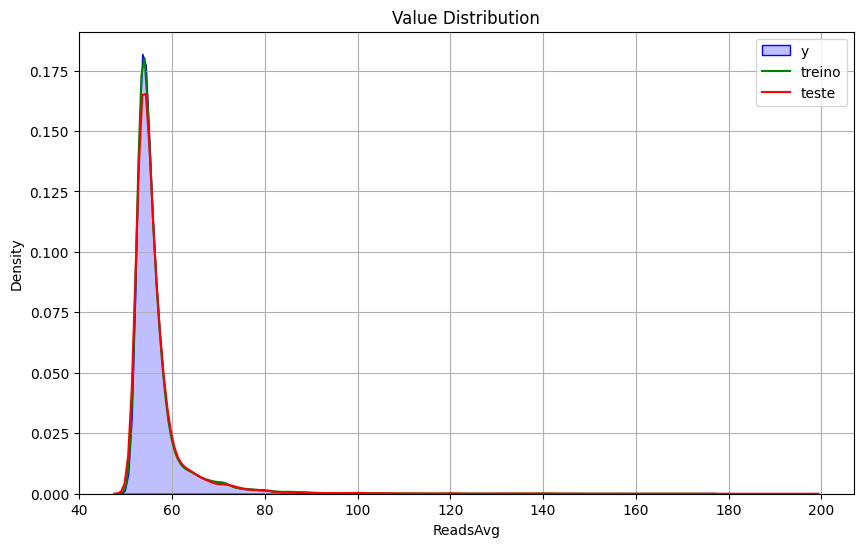

In [13]:
# Run RandomForestRegressor using feature with moderate correlation
X_df_train_mod_corr = X_df_train_without_ts[moderate_corr] # X_dataset_norm.iloc[:, 1:]
print(X_df_train_mod_corr.shape)

x_train, x_test, y_train, y_test = train_test_split(X_df_train_mod_corr, y, test_size=0.33, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Rand. Forest NMAE: {nmae(predicted, y_test)}')

plot_mea_est['rf_mod_corr'] = {
    'measured': y_test,
    'estimated': predicted
}

random_forest_model_aux = random_forest_model

fig1 = plt.figure(figsize=(10, 6))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='treino')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='teste')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

(26488, 70)
XGBoostRegressor Training time: 1.485646s
XGBoost Regressor NMAE: ReadsAvg    0.04466
dtype: float64


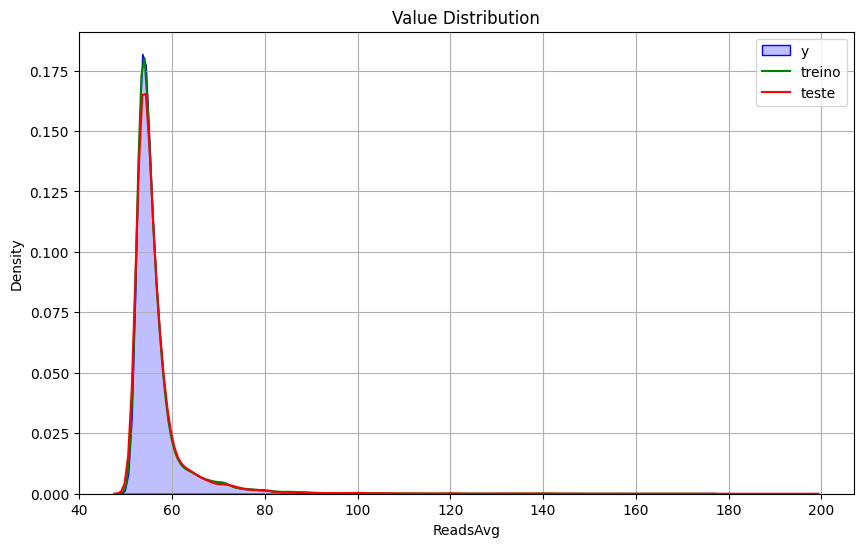

In [20]:
# Run XGBoostRegressor using feature with moderate correlation
X_df_train_mod_corr = X_df_train_without_ts[moderate_corr]
print(X_df_train_mod_corr.shape)

x_train, x_test, y_train, y_test = train_test_split(X_df_train_mod_corr, y, test_size=0.33, random_state=42)
model = XGBRegressor(n_estimators=120, max_depth=4, eval_metric=mean_absolute_error)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoostRegressor Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'XGBoost Regressor NMAE: {nmae(predicted, y_test)}')

plot_mea_est['xgb_mod_corr'] = {
    'measured': y_test,
    'estimated': predicted
}

fig2 = plt.figure(figsize=(10, 6))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='treino')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='teste')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

RFE time: 714.237405s


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rand. Forest Training time: 2.688494s
Rand. Forest NMAE: ReadsAvg    0.04441
dtype: float64


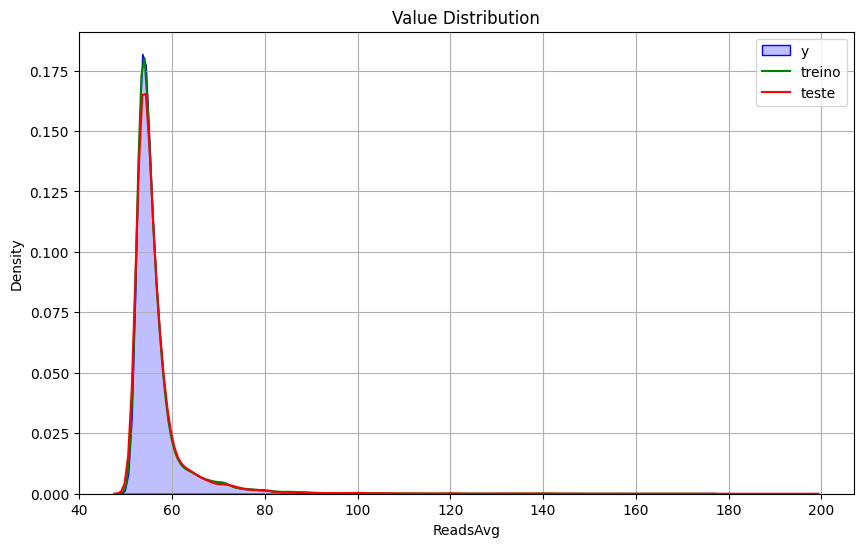

In [21]:
# Run RandomForestRegressor using RFE to reduce dimensionality
time = datetime.datetime.now(tz=datetime.timezone.utc)
n_features_to_select = 10
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_features_to_select)
rfe.fit(X_df_train_without_ts, y)
rfe_support = rfe.get_support()
X_df_train_mod_ref = X_df_train_without_ts.loc[:, rfe_support]
print(f'RFE time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

x_train, x_test, y_train, y_test = train_test_split(X_df_train_mod_ref, y, test_size=0.33, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Rand. Forest NMAE: {nmae(predicted, y_test)}')

plot_mea_est['rf_ref'] = {
    'measured': y_test,
    'estimated': predicted
}

fig3 = plt.figure(figsize=(10, 6))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='treino')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='teste')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
X_df_train_mod_ref.head()

,0_RxPacktes,6_RxPacktes,20_TxPacktes,23_RxPacktes,29_RxPacktes,30_RxPacktes,34_TxBytes,36_TxPacktes,36_TxBytes,42_TxBytes
0,0.416197,0.470808,0.329173,0.432582,0.086529,0.176386,0.155974,0.074131,0.138057,0.798280
1,0.599180,0.556348,0.556051,0.430366,0.461580,0.467058,0.162586,0.168489,0.217020,0.703367
2,0.450538,0.458248,0.438043,0.467307,0.377473,0.359817,0.156611,0.126285,0.237396,0.581083
3,0.471348,0.497624,0.390907,0.452900,0.396178,0.390868,0.165518,0.129565,0.241595,0.678533
4,0.503537,0.459946,0.430020,0.421869,0.364419,0.383823,0.186493,0.127542,0.231771,0.699056


RFE time: 662.816068s
XGBoostRegressor Training time: 10.067963s
XGBoost Regressor NMAE: ReadsAvg    0.048055
dtype: float64


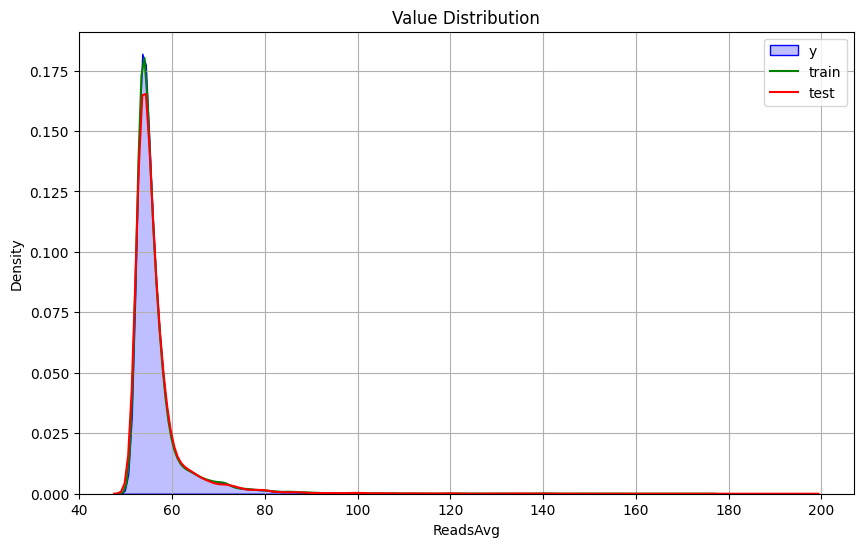

In [55]:
# Run XGBRegressor using RFE to reduce dimensionality
time = datetime.datetime.now(tz=datetime.timezone.utc)
n_features_to_select = 10
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_features_to_select)
rfe.fit(X_df_train_without_ts, y)
rfe_support = rfe.get_support()
X_df_train_mod_ref = X_df_train_without_ts.loc[:, rfe_support]
print(f'RFE time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

x_train, x_test, y_train, y_test = train_test_split(X_df_train_mod_ref, y, test_size=0.33, random_state=42)
model = XGBRegressor(n_estimators=1000, max_depth=7, eval_metric=mean_absolute_error)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'XGBoostRegressor Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'XGBoost Regressor NMAE: {nmae(predicted, y_test)}')

plot_mea_est['xgb_ref'] = {
    'measured': y_test,
    'estimated': predicted
}

fig4 = plt.figure(figsize=(10, 6))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='train')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='test')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

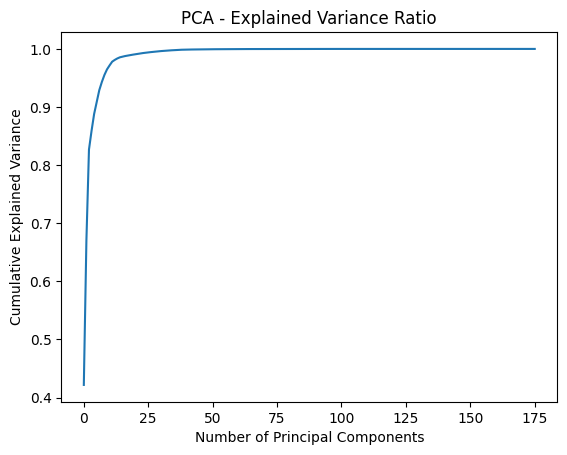

Number of components that explain 95.0% variance: 9


In [11]:
# Run RandomForestRegressor using PCA to reduce dimensionality
# use this to find a good number of components to explain the variance in the data: https://medium.com/@riya190304/finding-optimal-number-of-components-in-pca-2141d2891bed
pca = PCA()
pca.fit(X_df_train_without_ts)

fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Saving plot...
# fig.savefig('pictures/pca_explained_variance_ratio.png', dpi=fig.dpi, format='png')

threshold = 0.95  # For 90% explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Number of components that explain {threshold*100}% variance: {n_components}")

PCA shape: (26488, 9)


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rand. Forest Training time: 2.236584s
Rand. Forest NMAE: ReadsAvg    0.045931
dtype: float64


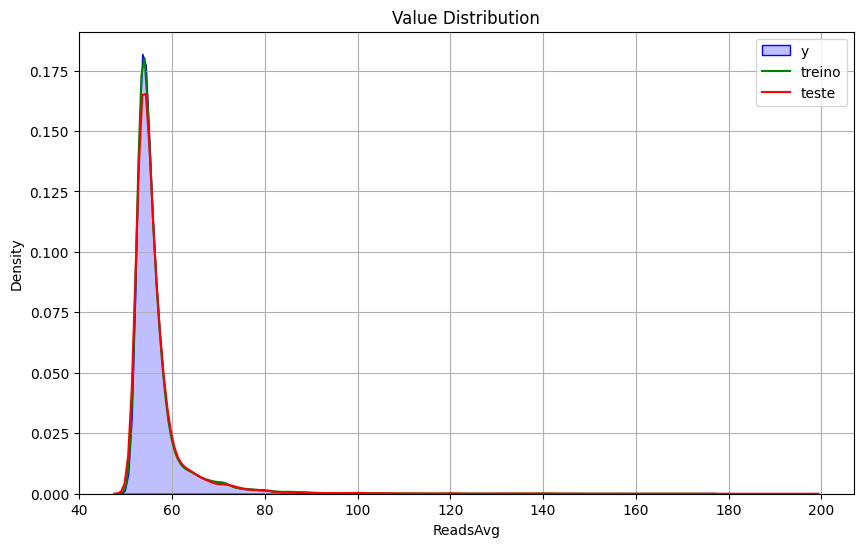

In [23]:
pca = PCA(n_components=9) # using 9 components that explain 95% variance in our dataset...
X_df_train_pca = pca.fit_transform(X_df_train_without_ts)

print(f"PCA shape: {X_df_train_pca.shape}")

# train and predict with PCA and RandomForestRegressor...
x_train, x_test, y_train, y_test = train_test_split(X_df_train_pca, y, test_size=0.33, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Rand. Forest NMAE: {nmae(predicted, y_test)}')

plot_mea_est['rf_pca'] = {
    'measured': y_test,
    'estimated': predicted
}

fig5 = plt.figure(figsize=(10, 6))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='treino')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='teste')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

PCA shape: (26488, 9)
Rand. Forest Training time: 4.587989s
Rand. Forest NMAE: ReadsAvg    0.051132
dtype: float64


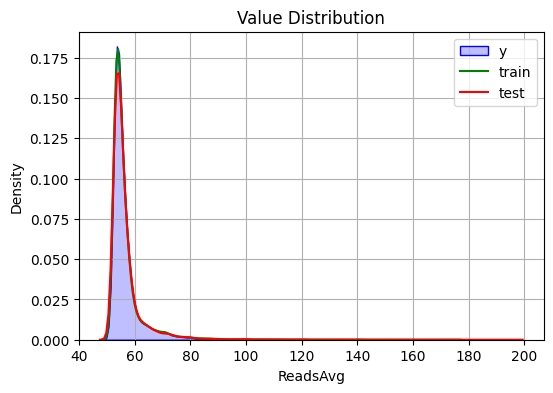

In [47]:
# XGBoostRegressor with PCA
pca = PCA(n_components=9) # using 9 components that explain 95% variance in our dataset...
X_df_train_pca = pca.fit_transform(X_df_train_without_ts)

print(f"PCA shape: {X_df_train_pca.shape}")

# train and predict with PCA and RandomForestRegressor...
x_train, x_test, y_train, y_test = train_test_split(X_df_train_pca, y, test_size=0.33, random_state=42)
model = XGBRegressor(n_estimators=1000, max_depth=7, eval_metric=mean_absolute_error)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Rand. Forest NMAE: {nmae(predicted, y_test)}')

plot_mea_est['xgb_pca'] = {
    'measured': y_test,
    'estimated': predicted
}

fig6 = plt.figure(figsize=(6, 4))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=y_train.squeeze(), color='g', fill=False, label='train')
sns.kdeplot(data=y_test.squeeze(), color='r', fill=False, label='test')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Saving plot...
fig6.savefig('pictures/value_distribution_y_ytrain_ytest.png', dpi=fig.dpi, format='png')

measured size: 8742
estimated size: 8742


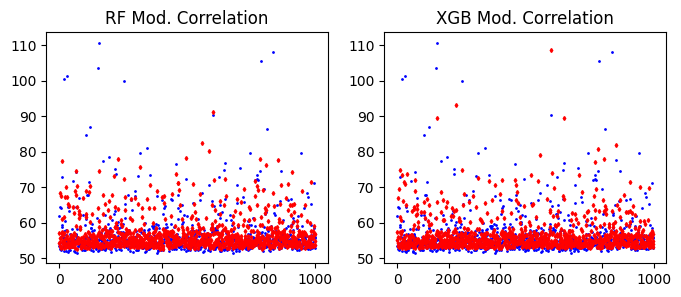

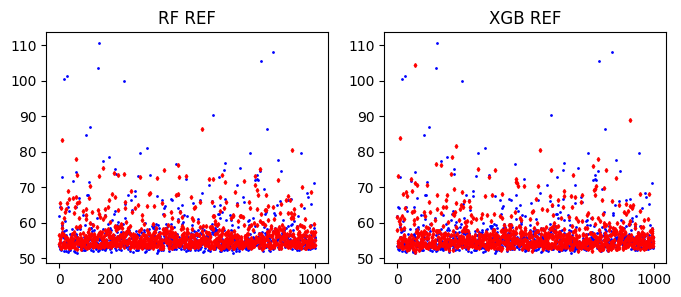

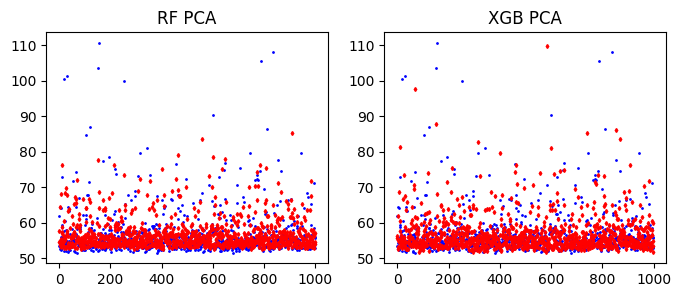

In [48]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(8, 3))

print(f"measured size: {len(plot_mea_est['rf_mod_corr']['measured'])}")
print(f"estimated size: {len(plot_mea_est['rf_mod_corr']['estimated'])}")

# RF Mod. Correlation
axis[0].plot(plot_mea_est['rf_mod_corr']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[0].plot(plot_mea_est['rf_mod_corr']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[0].set_title("RF Mod. Correlation")

# XGB Mod. Correlation
axis[1].plot(plot_mea_est['xgb_mod_corr']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[1].plot(plot_mea_est['xgb_mod_corr']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[1].set_title("XGB Mod. Correlation")

# Combine all the operations and display
plt.show()

# Saving plot...
figure.savefig('pictures/measured_predictec_mod_corr.png', dpi=fig.dpi, format='png')

figure, axis = plt.subplots(1, 2, figsize=(8, 3))

# RF REF
axis[0].plot(plot_mea_est['rf_ref']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[0].plot(plot_mea_est['rf_ref']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[0].set_title("RF REF")

# XGB REF
axis[1].plot(plot_mea_est['xgb_ref']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[1].plot(plot_mea_est['xgb_ref']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[1].set_title("XGB REF")

# Combine all the operations and display
plt.show()

# Saving plot...
figure.savefig('pictures/measured_predictec_ref.png', dpi=fig.dpi, format='png')

figure, axis = plt.subplots(1, 2, figsize=(8, 3))

# RF PCA
axis[0].plot(plot_mea_est['rf_pca']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[0].plot(plot_mea_est['rf_pca']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[0].set_title("RF PCA")

# XGB PCA
axis[1].plot(plot_mea_est['xgb_pca']['measured'][:1000].values.ravel(), marker='.', markersize=2, linestyle="None", color='blue', label='Measured')
axis[1].plot(plot_mea_est['xgb_pca']['estimated'][:1000], marker='d', markersize=2, linestyle="None", color='red', label='Predicted')
axis[1].set_title("XGB PCA")

# Combine all the operations and display
plt.show()

# # Saving plot...
figure.savefig('pictures/measured_predictec_pca.png', dpi=fig.dpi, format='png')

# plt.figure(figsize=(10, 6))
# sns.kdeplot(abs(y_previsto - y_test.values.ravel()), color='blue', fill=True, label='|y - ŷ|')
# plt.xlabel('|y - ŷ|')
# plt.ylabel('Densidade')
# plt.title('Distribuição de Valores')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.kdeplot(y['DispFrames'], color='blue', fill=True, label='y')
# sns.kdeplot(y_train['DispFrames'], color='green', fill=False, label='treino')
# sns.kdeplot(y_test['DispFrames'], color='red', fill=False, label='teste')
# plt.xlabel('Displayed Frames per sec')
# plt.ylabel('Densidade')
# plt.title('Distribuição de Valores')
# plt.legend()
# plt.grid(True)
# plt.show()

# RandomForest wit moderate correlations, RFE and PCA. With kfold

In [52]:
def nmae_paper(nmae_scores):
    # The scores will be negative, so take the negative to get the actual MAE
    mae_scores = -nmae_scores
    print(f"MAE scores {mae_scores}")
    print(type(mae_scores))
    
    y_mean = y.mean()
    nmae_scores = [score / y_mean for score in mae_scores]
    nmae_scores = np.array(nmae_scores)
    
    print(f"NMAE scores: {nmae_scores}")
    print(f"Mean NMAE scores : {nmae_scores.mean():.4f}")
    print(f"STD NMAE scores : {nmae_scores.std():.4f}")

In [29]:
# Run RandomForestRegressor using feature with moderate correlation and kfold
X_df_train_mod_corr = X_df_train_without_ts[moderate_corr]
# X_df_train_mod_corr.fillna(0)
# y_norm.fillna(0)

# print(X_df_train_mod_corr.shape)

# split train and test... and use train with kfold
# x_train, x_test, y_train, y_test = train_test_split(X_df_train_mod_corr, y, test_size=0.20, random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(random_forest_model, X_df_train_mod_corr, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartn

Cross-validation scores: [-2.54500594 -2.50924165 -2.54945313 -2.39007096 -2.42832015 -2.45765551
 -2.52493159 -2.54440344 -2.5232062  -2.3852186 ]
Mean nmae: -2.4858
Standard deviation of accuracy: 0.0615
MAE scores [2.54500594 2.50924165 2.54945313 2.39007096 2.42832015 2.45765551
 2.52493159 2.54440344 2.5232062  2.3852186 ]
<class 'numpy.ndarray'>
NMAE scores: [[0.0449281 ]
 [0.04429674]
 [0.04500661]
 [0.04219297]
 [0.0428682 ]
 [0.04338607]
 [0.04457372]
 [0.04491747]
 [0.04454326]
 [0.04210731]]
Mean NMAE scores : 0.0439
STD NMAE scores : 0.0011


In [54]:
# Run XGBoostRegressor using feature with moderate correlation and kfold
X_df_train_mod_corr = X_df_train_without_ts[moderate_corr]
print(X_df_train_mod_corr.shape)

model = XGBRegressor(n_estimators=1000, max_depth=7, eval_metric=mean_absolute_error)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(model, X_df_train_mod_corr, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

(26488, 70)
Cross-validation scores: [-2.66455889 -2.62516046 -2.71729374 -2.57991576 -2.57617927 -2.57206964
 -2.61993146 -2.76217461 -2.66694856 -2.54471445]
Mean nmae: -2.6329
Standard deviation of accuracy: 0.0661
MAE scores [2.66455889 2.62516046 2.71729374 2.57991576 2.57617927 2.57206964
 2.61993146 2.76217461 2.66694856 2.54471445]
<class 'numpy.ndarray'>
NMAE scores: [[0.04703862]
 [0.04634311]
 [0.04796958]
 [0.04554438]
 [0.04547842]
 [0.04540587]
 [0.0462508 ]
 [0.04876188]
 [0.04708081]
 [0.04492296]]
Mean NMAE scores : 0.0465
STD NMAE scores : 0.0012


In [31]:
# Run RandomForestRegressor using RFE to reduce dimensionality and KFold
time = datetime.datetime.now(tz=datetime.timezone.utc)
n_features_to_select = 10
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_features_to_select)
rfe.fit(X_df_train_without_ts, y)
rfe_support = rfe.get_support()
X_df_train_mod_ref = X_df_train_without_ts.loc[:, rfe_support]
print(f'RFE time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(model, X_df_train_mod_ref, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

RFE time: 669.49871s


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartn

Cross-validation scores: [-2.56821574 -2.49832133 -2.54640537 -2.4677695  -2.43919739 -2.47045121
 -2.50350273 -2.54449543 -2.51611328 -2.34892497]
Mean nmae: -2.4903
Standard deviation of accuracy: 0.0605
MAE scores [2.56821574 2.49832133 2.54640537 2.4677695  2.43919739 2.47045121
 2.50350273 2.54449543 2.51611328 2.34892497]
<class 'numpy.ndarray'>
NMAE scores: [[0.04533784]
 [0.04410396]
 [0.04495281]
 [0.04356462]
 [0.04306022]
 [0.04361196]
 [0.04419543]
 [0.04491909]
 [0.04441805]
 [0.0414666 ]]
Mean NMAE scores : 0.0440
STD NMAE scores : 0.0011


In [32]:
# Run RandomForestRegressor using RFE to reduce dimensionality and KFold
time = datetime.datetime.now(tz=datetime.timezone.utc)
n_features_to_select = 10
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=n_features_to_select)
rfe.fit(X_df_train_without_ts, y)
rfe_support = rfe.get_support()
X_df_train_mod_ref = X_df_train_without_ts.loc[:, rfe_support]
print(f'RFE time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

model = XGBRegressor(n_estimators=1000, max_depth=7, eval_metric=mean_absolute_error)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(model, X_df_train_mod_ref, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

RFE time: 672.161536s
Cross-validation scores: [-2.77666831 -2.71540976 -2.79094934 -2.67237854 -2.65838337 -2.67346621
 -2.75583744 -2.70973754 -2.73167038 -2.56069779]
Mean nmae: -2.7045
Standard deviation of accuracy: 0.0640
MAE scores [2.77666831 2.71540976 2.79094934 2.67237854 2.65838337 2.67346621
 2.75583744 2.70973754 2.73167038 2.56069779]
<class 'numpy.ndarray'>
NMAE scores: [[0.04901774]
 [0.04793632]
 [0.04926985]
 [0.04717667]
 [0.04692961]
 [0.04719587]
 [0.04865   ]
 [0.04783618]
 [0.04822337]
 [0.04520512]]
Mean NMAE scores : 0.0477
STD NMAE scores : 0.0011


In [33]:
# RandomForest with PCA and KFold
pca = PCA(n_components=9) # using 9 components that explain 95% variance in our dataset...
X_df_train_pca = pca.fit_transform(X_df_train_without_ts)

print(f"PCA shape: {X_df_train_pca.shape}")

# train and predict with PCA and RandomForestRegressor...
model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(model, X_df_train_pca, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

PCA shape: (26488, 9)


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/johny/environment/repositories/smartn

Cross-validation scores: [-2.66874902 -2.5215586  -2.62256913 -2.47811721 -2.50134632 -2.49190411
 -2.55199164 -2.62421375 -2.56420307 -2.4682249 ]
Mean nmae: -2.5493
Standard deviation of accuracy: 0.0659
MAE scores [2.66874902 2.5215586  2.62256913 2.47811721 2.50134632 2.49190411
 2.55199164 2.62421375 2.56420307 2.4682249 ]
<class 'numpy.ndarray'>
NMAE scores: [[0.04711259]
 [0.04451418]
 [0.04629736]
 [0.04374729]
 [0.04415736]
 [0.04399067]
 [0.04505143]
 [0.04632639]
 [0.045267  ]
 [0.04357265]]
Mean NMAE scores : 0.0450
STD NMAE scores : 0.0012


In [34]:
# RandomForest with PCA and KFold
pca = PCA(n_components=9) # using 9 components that explain 95% variance in our dataset...
X_df_train_pca = pca.fit_transform(X_df_train_without_ts)

print(f"PCA shape: {X_df_train_pca.shape}")

model = XGBRegressor(n_estimators=1000, max_depth=7, eval_metric=mean_absolute_error)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42) # 10 folds, shuffle data

# Perform cross-validation
scores = cross_val_score(model, X_df_train_pca, y, cv=kf, scoring='neg_mean_absolute_error') # Adjust scoring metric

print(f"Cross-validation scores: {scores}")
print(f"Mean nmae: {scores.mean():.4f}")
print(f"Standard deviation of accuracy: {scores.std():.4f}")

nmae_paper(scores)

PCA shape: (26488, 9)
Cross-validation scores: [-2.96865749 -2.83019114 -2.88509035 -2.76462436 -2.73096061 -2.77150869
 -2.87178993 -2.98582816 -2.85842371 -2.73822808]
Mean nmae: -2.8405
Standard deviation of accuracy: 0.0860
MAE scores [2.96865749 2.83019114 2.88509035 2.76462436 2.73096061 2.77150869
 2.87178993 2.98582816 2.85842371 2.73822808]
<class 'numpy.ndarray'>
NMAE scores: [[0.05240701]
 [0.0499626 ]
 [0.05093176]
 [0.04880512]
 [0.04821084]
 [0.04892666]
 [0.05069696]
 [0.05271013]
 [0.050461  ]
 [0.04833914]]
Mean NMAE scores : 0.0501
STD NMAE scores : 0.0015


# Dataset single app

In [14]:
# Compare these experiments.
sa_x_dataset_raw = pd.read_csv('datasets/KV-SingleApp-PeriodicLoad/X_port.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(sa_x_dataset_raw.shape)
print(sa_x_dataset_raw.iloc[0, 0])
print(sa_x_dataset_raw.iloc[-1, 0])
sa_x_dataset_raw.head(5)

(28962, 177)
1479626031
1479670970


,TimeStamp,0_RxPacktes,0_TxPacktes,0_RxBytes,0_TxBytes,1_RxPacktes,1_TxPacktes,1_RxBytes,1_TxBytes,2_RxPacktes,...,41_RxBytes,41_TxBytes,42_RxPacktes,42_TxPacktes,42_RxBytes,42_TxBytes,43_RxPacktes,43_TxPacktes,43_RxBytes,43_TxBytes
0,1479626031,1895,2435,928722,1063358,2078,1636,566909,1205475,0,...,121659,293712,1141,1448,670697,830824,1447,1137,519438,1102757
1,1479626038,4886,6091,2449410,3732594,1515,1189,567577,1087380,0,...,1603670,2822663,1077,1382,628495,757195,1368,1079,473436,1056894
2,1479626041,3856,4937,2082394,2871737,1440,1099,528141,1014411,0,...,1272053,2442247,1102,1412,639826,821355,1414,1100,514485,1068355
3,1479626042,4148,5164,2302054,2947672,1463,1154,538810,1091701,0,...,1286837,2663940,1046,1296,592086,723816,1295,1038,452580,986490
4,1479626043,4043,4842,2097150,2837621,1337,1066,465600,1045230,0,...,1373232,2557414,1255,1600,672795,979333,1603,1260,610214,1120542


In [37]:
# Identify columns to normalize (all except the first)
sa_cols_to_normalize = sa_x_dataset_raw.columns[1:]

# Extract the columns to be normalized
sa_df_to_normalize = sa_x_dataset_raw[sa_cols_to_normalize]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
sa_normalized_data = scaler.fit_transform(sa_df_to_normalize)

# Create a new DataFrame with the normalized values
sa_x_dataset_norm = pd.DataFrame(sa_normalized_data, columns=sa_cols_to_normalize, index=sa_x_dataset_raw.index)

# Concatenate the first column with the normalized DataFrame
sa_x_dataset_norm = pd.concat([sa_x_dataset_raw.iloc[:, :1], sa_x_dataset_norm], axis=1)

# Print the final DataFrame
print(sa_x_dataset_norm.shape)
sa_x_dataset_norm.head(5)

(28962, 177)


,TimeStamp,0_RxPacktes,0_TxPacktes,0_RxBytes,0_TxBytes,1_RxPacktes,1_TxPacktes,1_RxBytes,1_TxBytes,2_RxPacktes,...,41_RxBytes,41_TxBytes,42_RxPacktes,42_TxPacktes,42_RxBytes,42_TxBytes,43_RxPacktes,43_TxPacktes,43_RxBytes,43_TxBytes
0,1479626031,0.168736,0.165015,0.146182,0.124069,0.862241,0.931133,0.594044,0.699099,0.0,...,0.016531,0.007823,0.640651,0.584106,0.642889,0.579918,0.583233,0.640563,0.544013,0.636712
1,1479626038,0.480852,0.454783,0.434281,0.486090,0.628631,0.676722,0.594744,0.630611,0.0,...,0.391706,0.351355,0.604716,0.557483,0.602437,0.528525,0.551391,0.607887,0.495834,0.610232
2,1479626041,0.373370,0.363319,0.364748,0.369335,0.597510,0.625498,0.553420,0.588294,0.0,...,0.307756,0.299679,0.618754,0.569585,0.613298,0.573309,0.569931,0.619718,0.538825,0.616849
3,1479626042,0.403840,0.381311,0.406364,0.379633,0.607054,0.656801,0.564600,0.633117,0.0,...,0.311499,0.329794,0.587310,0.522791,0.567538,0.505226,0.521967,0.584789,0.473992,0.569582
4,1479626043,0.392883,0.355790,0.367544,0.364707,0.554772,0.606716,0.487886,0.606167,0.0,...,0.333370,0.315324,0.704660,0.645422,0.644900,0.683578,0.646110,0.709859,0.639083,0.646981


In [16]:
sa_y_dataset = pd.read_csv('datasets/KV-SingleApp-PeriodicLoad/Y.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
sa_y_dataset.head(5)

,TimeStamp,ReadsAvg,WritesAvg
0,1479626031,73.8254,175.5445
1,1479626038,56.2413,115.2276
2,1479626041,56.8517,120.2875
3,1479626042,56.9347,108.4472
4,1479626043,60.5642,108.4257


In [17]:
sa_y = sa_y_dataset[['ReadsAvg']].copy()
sa_y.head(5)

,ReadsAvg
0,73.8254
1,56.2413
2,56.8517
3,56.9347
4,60.5642


In [38]:
# use this https://www.digitalocean.com/community/tutorials/multiple-linear-regression-python#using-statsmodels, to get some statistical information...
sa_x_df_train_without_ts = sa_x_dataset_norm.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
sa_y_normalized_data = scaler.fit_transform(sa_y)

# Create a new DataFrame with the normalized values
sa_y_norm = pd.DataFrame(sa_y_normalized_data, index=sa_y.index)

In [41]:
sa_correlations = []

# print(X_df_train_without_ts)
# print(y_norm)

for idx, col in enumerate(sa_x_df_train_without_ts.columns):
    # print(X_df_train_without_ts[col])
    # print(y_norm.iloc[:,0])
    # break
    sa_correlations.append([col, sa_x_df_train_without_ts[col].corr(sa_y_norm.iloc[:,0])])

print(len(sa_correlations))

176


Strong corr: 48
Moderate corr: 0
Weak corr: 128


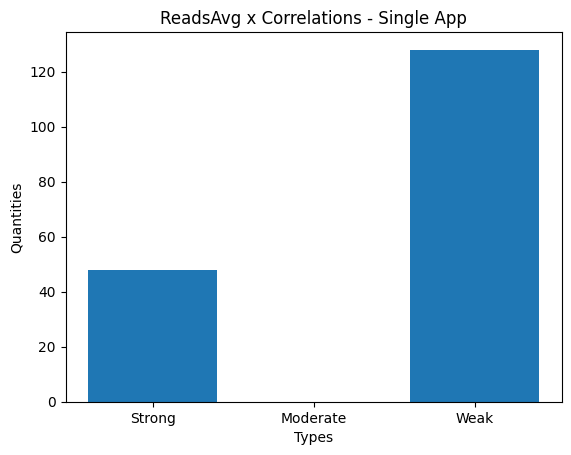

In [46]:
# create a plot with quantity of columns as of strong, medium and low correlation...
# Strong Correlation:
# A correlation coefficient of 0.5 to 1.0 (positive) or -0.5 to -1.0 (negative). 
# Moderate Correlation:
# A correlation coefficient of 0.3 to 0.5 (positive) or -0.3 to -0.5 (negative).
# Weak Correlation:
# A correlation coefficient of 0.1 to 0.3 (positive) or -0.1 to -0.3 (negative).
sa_strong_corr = []
sa_moderate_corr = []
sa_weak_corr = []

for col_corr in sa_correlations:
    if not np.isnan(col_corr[1]):
        if 1.0 >= col_corr[1] > 0.5 or -0.5 > col_corr[1] >= -1.0:
            sa_strong_corr.append(col_corr[0])
        elif 0.5 >= col_corr[1] > 0.3 or -0.3 > col_corr[1] >= -0.5:
            sa_moderate_corr.append(col_corr[0])
        elif 0.3 >= col_corr[1] > 0.0 or -0.1 >= col_corr[1] >= -0.3:
            sa_weak_corr.append(col_corr[0])
        else:
            sa_weak_corr.append(col_corr[0])
    else:
        sa_weak_corr.append(col_corr[0])

print('Strong corr:', len(sa_strong_corr))
print('Moderate corr:', len(sa_moderate_corr))
print('Weak corr:', len(sa_weak_corr))

correlation_bar = np.array([len(sa_strong_corr), len(sa_moderate_corr), len(sa_weak_corr)])

# plot
corr_types = ['Strong', 'Moderate', 'Weak']

fig = plt.figure()
plt.bar(corr_types, correlation_bar)
plt.title('ReadsAvg x Correlations - Single App')
plt.xlabel('Types')
plt.ylabel('Quantities')
plt.show()

In [45]:
# Saving plot...
fig.savefig('pictures/sa_corr_readsavg_qty_features.png', dpi=fig.dpi, format='png')

(28962, 70)


/home/johny/environment/repositories/smartness-experiments/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Rand. Forest Training time: 17.221115s
Rand. Forest NMAE: ReadsAvg    0.023991
dtype: float64


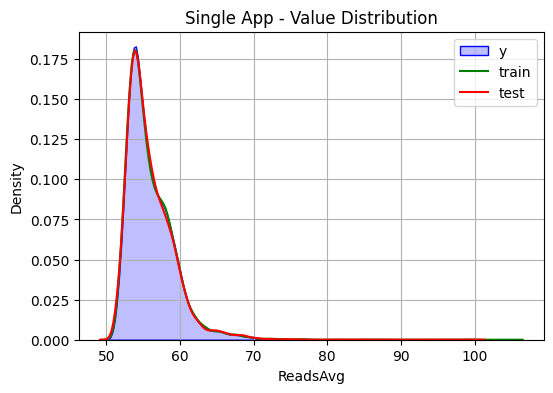

In [43]:
# Run RandomForestRegressor using feature with moderate correlation
sa_x_df_train_mod_corr = sa_x_df_train_without_ts[moderate_corr] # X_dataset_norm.iloc[:, 1:]
print(sa_x_df_train_mod_corr.shape)

sa_x_train, sa_x_test, sa_y_train, sa_y_test = train_test_split(sa_x_df_train_mod_corr, sa_y, test_size=0.33, random_state=42)
sa_model = RandomForestRegressor(n_estimators=120, random_state=None, n_jobs=-1)

time = datetime.datetime.now(tz=datetime.timezone.utc)
sa_model.fit(sa_x_train, sa_y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

sa_predicted = sa_model.predict(sa_x_test)
print(f'Rand. Forest NMAE: {nmae(sa_predicted, sa_y_test)}')

plot_mea_est['sa_rf_mod_corr'] = {
    'measured': sa_y_test,
    'estimated': sa_predicted
}

sa_fig1 = plt.figure(figsize=(6, 4))
sns.kdeplot(data=sa_y.squeeze(), color='b', fill=True, label='y')
sns.kdeplot(data=sa_y_train.squeeze(), color='g', fill=False, label='train')
sns.kdeplot(data=sa_y_test.squeeze(), color='r', fill=False, label='test')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Single App - Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Saving plot...
# sa_fig1.savefig('pictures/sa_value_distribution_y_ytrain_ytest.png', dpi=fig.dpi, format='png')

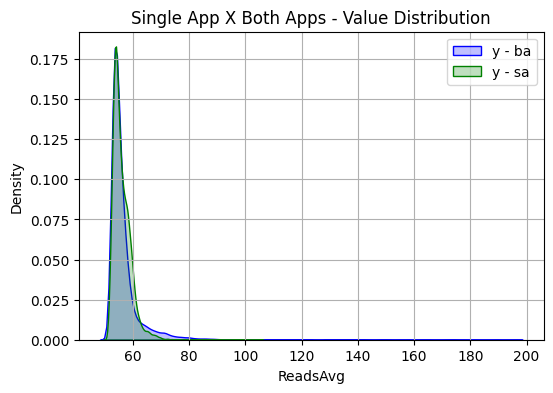

In [51]:
sa_fig2 = plt.figure(figsize=(6, 4))
sns.kdeplot(data=y.squeeze(), color='b', fill=True, label='y - ba')
sns.kdeplot(data=sa_y.squeeze(), color='g', fill=True, label='y - sa')
plt.xlabel('ReadsAvg')
plt.ylabel('Density')
plt.title('Single App X Both Apps - Value Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Saving plot...
sa_fig2.savefig('pictures/sa_value_distribution_yba_ysa.png', dpi=fig.dpi, format='png')

In [32]:
# Run RandomForestRegressor using feature with moderate correlation
sa_x_df_train_mod_corr = sa_x_df_train_without_ts[moderate_corr] # X_dataset_norm.iloc[:, 1:]
print(sa_x_df_train_mod_corr.shape)

sa_x_train, sa_x_test, sa_y_train, sa_y_test = train_test_split(sa_x_df_train_mod_corr, sa_y, test_size=0.33, random_state=42)

sa_predicted = random_forest_model_aux.predict(sa_x_test)
print(f'Both Apps Rand. Forest Model NMAE: {nmae(sa_predicted, sa_y_test)}')

plot_mea_est['sa_rf_mod_corr'] = {
    'measured': sa_y_test,
    'estimated': sa_predicted
}

(28962, 70)
Both Apps Rand. Forest Model NMAE: ReadsAvg    0.062198
dtype: float64
